# Helping chemists design selective JAK inhibitors

# The dataset

Here's the kinase dataset we'd like you to work with:

In [1]:
import pandas as pd
df = pd.read_csv('./kinase_JAK.csv')
df.head()
df.groupby(['measurement_type']).count()

,SMILES,measurement_value,Kinase_name
measurement_type,,,
pIC50,8736,8736,8736
pKi,1989,1989,1989


There are 10725 measurements in total.

SMILES is a text encoding of a molecular structure. You can read about it [here](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html), but you don't have to. 

measurement_type specifies how the measurement was being done. There are two types of measurements: pIC50 and pKi. For both measurements, a higher number means that the molecule binds stronger to the protein. 


measurement_value is the value of the measurement. 

Kinase_name is the name of the kinase that the molecule has been measured against. There are 4 different kinases in this dataset: JAK1, JAK2, JAK3, and TYR2. 

Our goal is to predict the pKi of a molecule against JAK1, JAK2, JAK3, and TYK2. 

# Basic RDKit¶


rdkit is the most popular cheminformatics package for python. Unfortunately it has awful documentation: http://rdkit.org/docs/index.html

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (400, 300)
IPythonConsole.ipython_useSVG=True

You can use it to visualize SMILES strings like this, if you want to visually inspect the data:


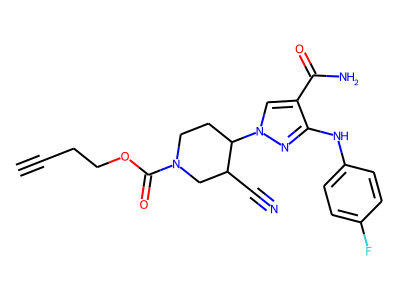

In [3]:
# Chem.MolFromSmiles returns a Chem.Mol object, which rdkit automatically visualizes in a jupyter notebook
Chem.MolFromSmiles(df['SMILES'][0])

# Tokenization

For text-based models, here is a tokenizer that can be used

In [4]:
def smiles_tokenizer(smi):
    """ 
    Tokenize a SMILES string representation of a molecule
    Returns a list of tokens in SMILES vocabulary
    """
    import re
    pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]
    assert smi == ''.join(tokens)
    return tokens

In [5]:
df_pIC50 = df[df['measurement_type']=='pIC50']
df_pKi   = df[df['measurement_type']=='pKi'].sample(frac=1)
N=df_pKi.shape[0]
ntest=int(0.2*N)
df_test = df_pKi.iloc[:ntest]
df_train = pd.concat([df_pKi.iloc[ntest:],df_pIC50]).sample(frac=1)



In [6]:
def pivot(df):
    return df.pivot(index='SMILES',columns=['Kinase_name','measurement_type'],values='measurement_value')

In [7]:
dfp_train = pivot(df_train)
dfp_test = pivot(df_test)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [10]:
import torch
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def data_process(raw_text_iter):
  data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [11]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [12]:
ntokens = len(vocab) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [13]:
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)



In [14]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 1370.08 | loss  8.10 | ppl  3280.21
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 809.57 | loss  6.88 | ppl   975.08
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 864.38 | loss  6.44 | ppl   625.47
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 896.26 | loss  6.29 | ppl   540.63
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 952.17 | loss  6.19 | ppl   485.74
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 924.24 | loss  6.15 | ppl   469.90
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 987.19 | loss  6.11 | ppl   450.94
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 1007.21 | loss  6.11 | ppl   450.41


KeyboardInterrupt: 

In [15]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

AttributeError: 'NoneType' object has no attribute 'eval'

In [16]:
print(best_model)

None
